In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import lmfit
from lmfit import  Model, Parameters

In [2]:
def fct_velocity_line(x, dir_target, start_anti, a_anti, latency, ramp_pursuit, steady_state, do_whitening) :

    a_anti = a_anti/1000 # to switch from sec to ms
    ramp_pursuit = dir_target*(ramp_pursuit)/1000
    time = x
    vitesse = []
    y = 0
    
    for t in range(len(time)):
        
        if start_anti >= latency :
            
            if time[t] < latency :
                vitesse.append(0)
                maxi = steady_state
                end_ramp_pursuit = ((dir_target*maxi)/ramp_pursuit) + latency
            else :
                if latency >= end_ramp_pursuit :
                    vitesse.append(dir_target*maxi)
                else :
                    if time[t] < end_ramp_pursuit : vitesse.append((time[t]-latency)*ramp_pursuit)
                    else :                          vitesse.append(dir_target*maxi)
        
        #-------------------------------------------------------------------------------
        else :
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latency :
                    vitesse.append((time[t]-start_anti)*a_anti)
                    y = (time[t]-start_anti)*a_anti
                    maxi = steady_state - y
                    end_ramp_pursuit = ((dir_target*maxi)/ramp_pursuit) + latency
                else :
                    if latency >= end_ramp_pursuit :
                        vitesse.append(dir_target*maxi)
                    else :
                        if time[t] < int(end_ramp_pursuit) : vitesse.append((time[t]-latency)*ramp_pursuit+y)
                        else :                vitesse.append(dir_target*maxi+y)
        
    if do_whitening is True : velocity = whitening(velocity)
    
    return vitesse

In [3]:
def fct_velocity_sigmo(x, dir_target, start_anti, a_anti, latency, ramp_pursuit, steady_state, do_whitening) :


    a_anti = a_anti/1000 # to switch from sec to ms
    ramp_pursuit = -ramp_pursuit/1000
    time = x
    velocity = []
    y = 0

    e = np.exp(1)
    time_r = np.arange(-e, len(time), 1)

    for t in range(len(time)):

        if start_anti >= latency :
            if time[t] < latency :
                velocity.append(0)
                maxi = steady_state
                start_rampe = dir_target*(maxi/(1+np.exp(((ramp_pursuit*time_r[0])+e))))
            else :
                velocity.append(((dir_target*maxi)/(1+np.exp(((ramp_pursuit*time_r[int(time[t]-latency)])+e))))-start_rampe)
        else :
            if time[t] < start_anti :
                velocity.append(0)
            else :
                if time[t] < latency :
                    velocity.append((time[t]-start_anti)*a_anti)
                    y = (time[t]-start_anti)*a_anti
                    maxi = steady_state - y
                    start_rampe = dir_target*(maxi/(1+np.exp(((ramp_pursuit*time_r[0])+e))))
                else :
                    velocity.append(((dir_target*maxi)/(1+np.exp(((ramp_pursuit*time_r[int(time[t]-latency)])+e))))+(y-start_rampe))

    if do_whitening is True : velocity = whitening(velocity)

    return velocity

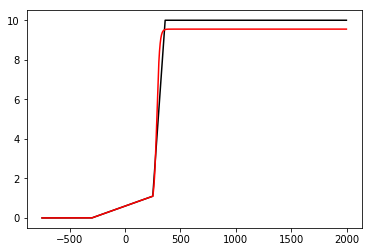

In [4]:
time = np.arange(-750, 2000)

line = fct_velocity_line(time, 1, -300, 2, 250, 80, 10, False)
sigmo = fct_velocity_sigmo(time, 1, -300, 2, 250, 80, 10, False)

plt.plot(time, line, 'k')
plt.plot(time, sigmo, 'r');

In [5]:
import pickle
with open('parametre/old_param/param_Fit_AM_fct_velocity_2_step_False_whitening.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
    
datafile = 'data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [6]:
A = ANEMO(exp)
Plot = ANEMO.Plot(exp)

/usr/local/lib/python3.5/dist-packages/ANEMO-0.0.1-py3.5.egg/ANEMO/ANEMO.py:661: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.5/dist-packages/ANEMO-0.0.1-py3.5.egg/ANEMO/ANEMO.py:682: RuntimeWarning: Mean of empty slice


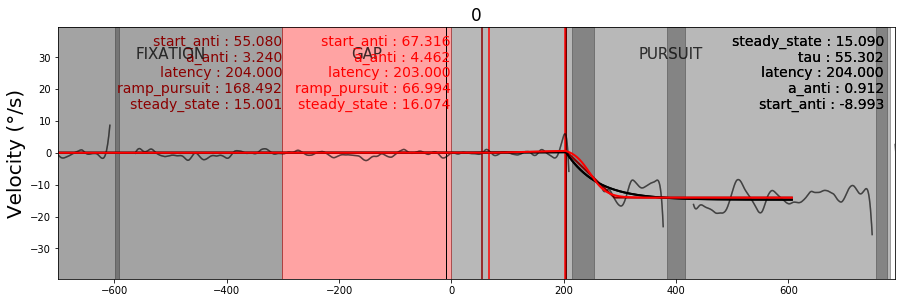

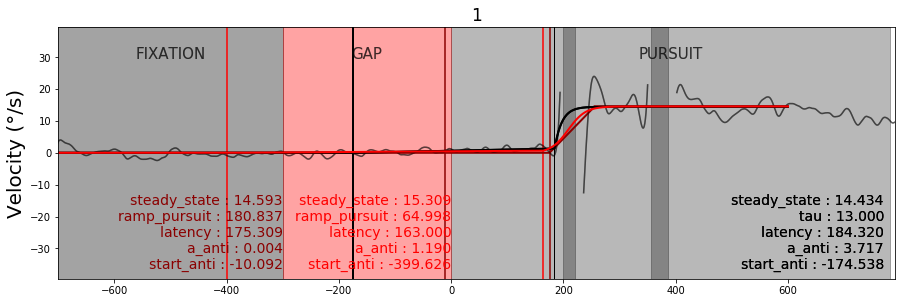

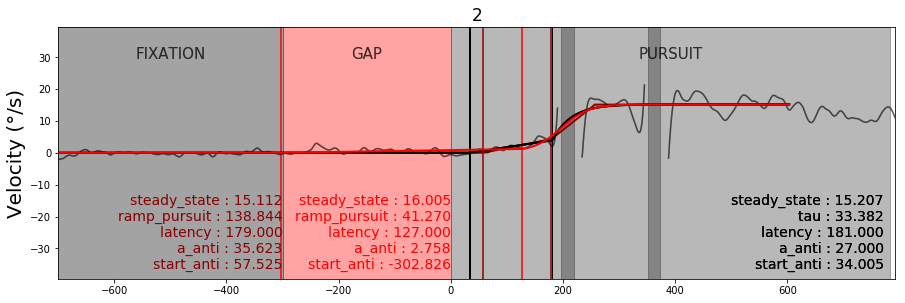

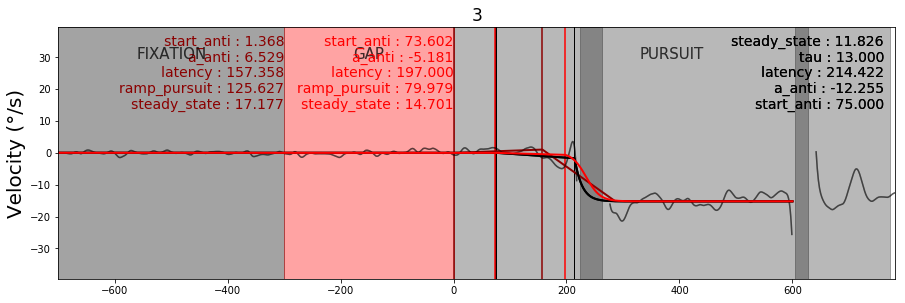

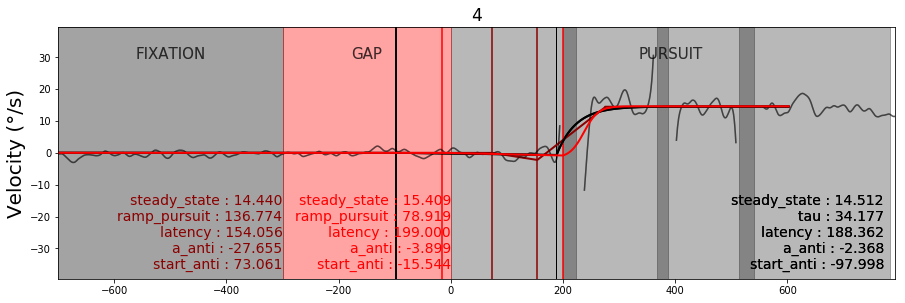

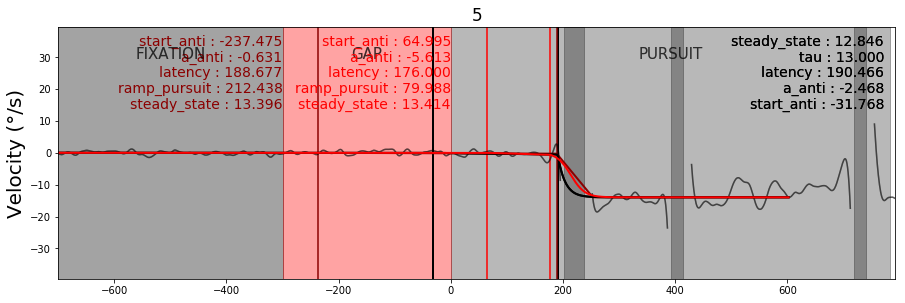

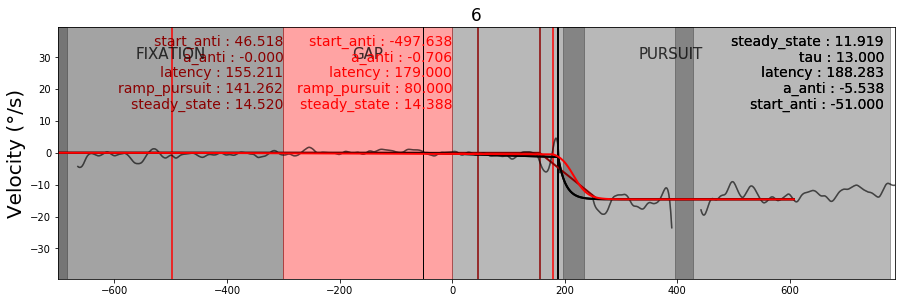

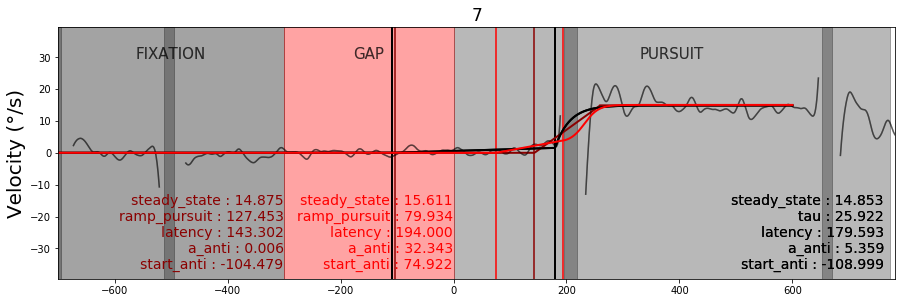

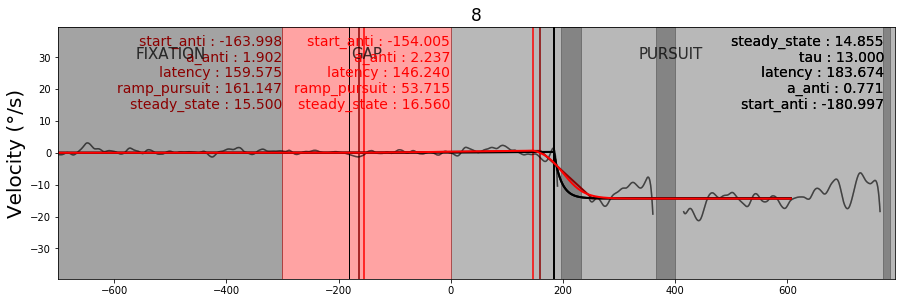

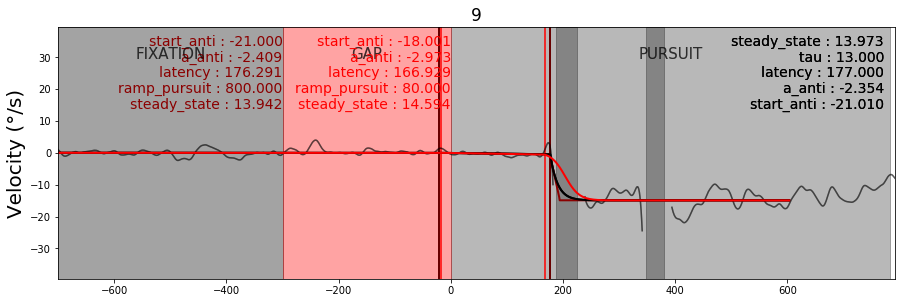

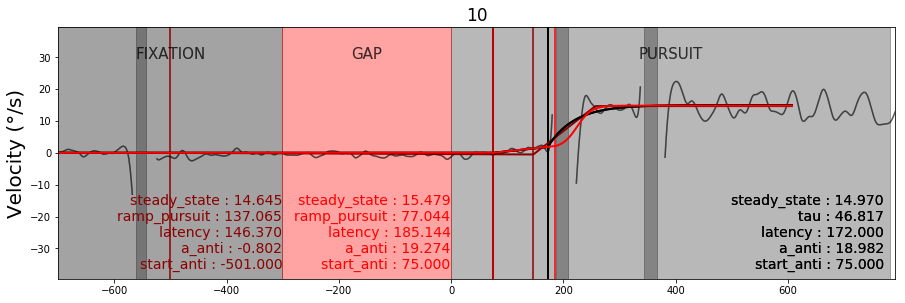

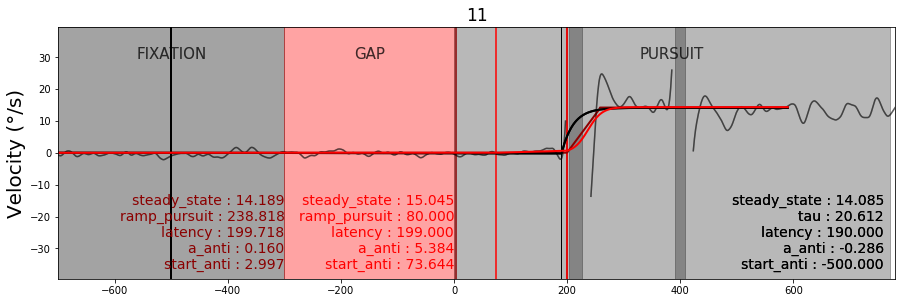

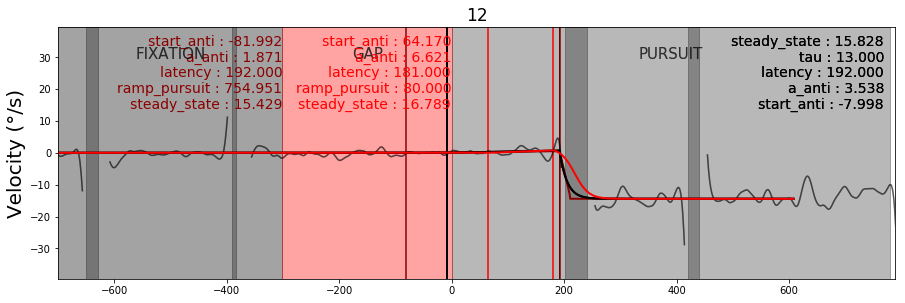

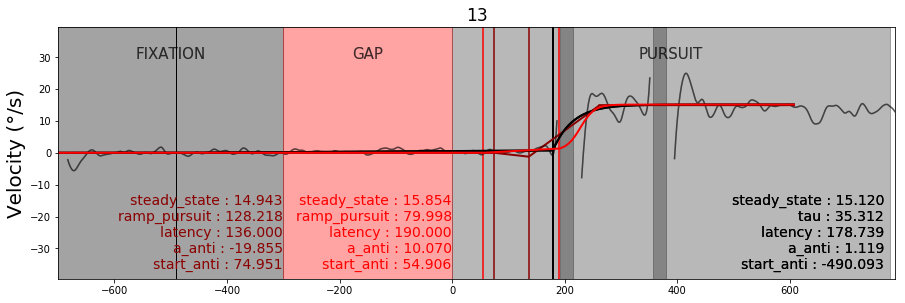

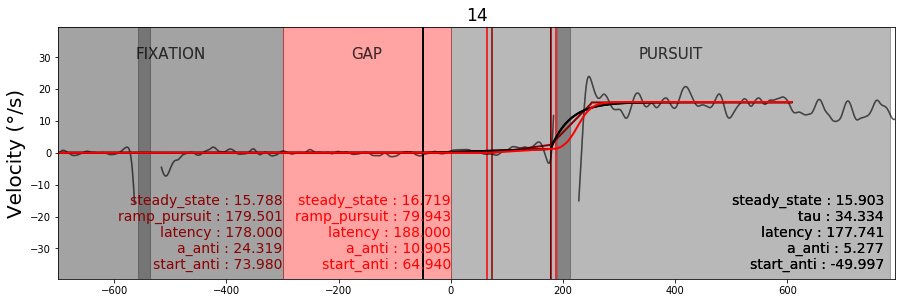

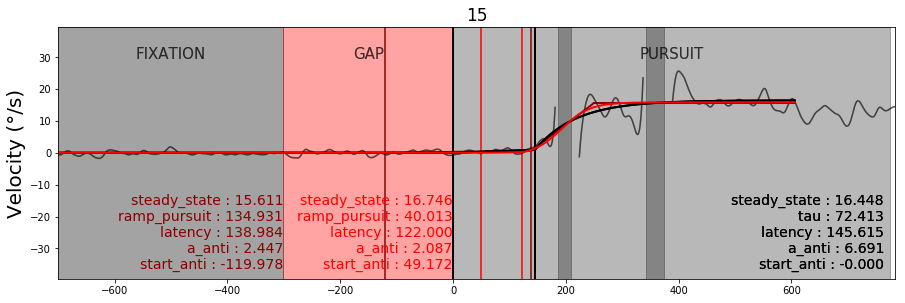

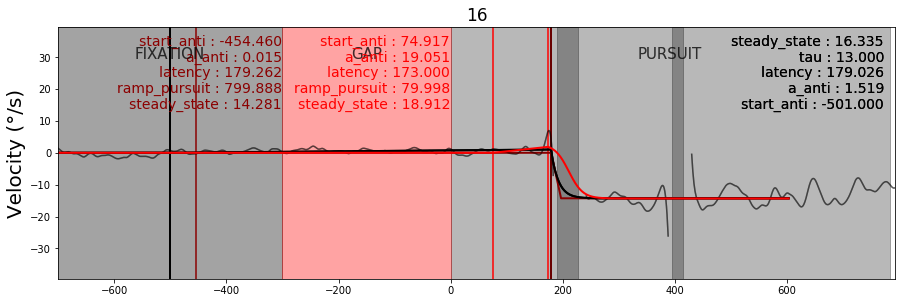

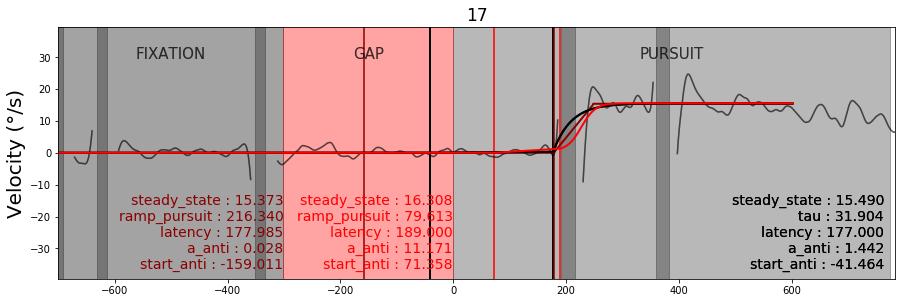

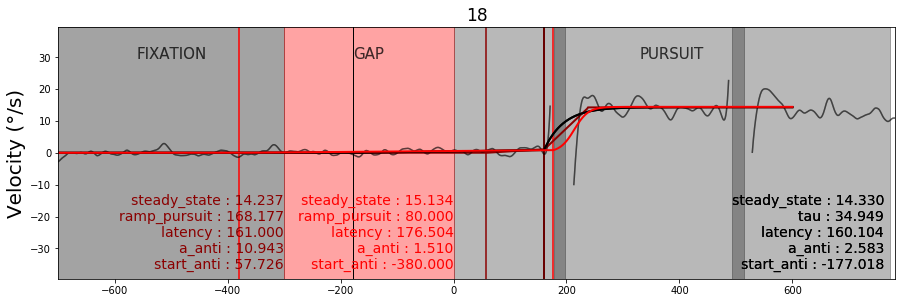

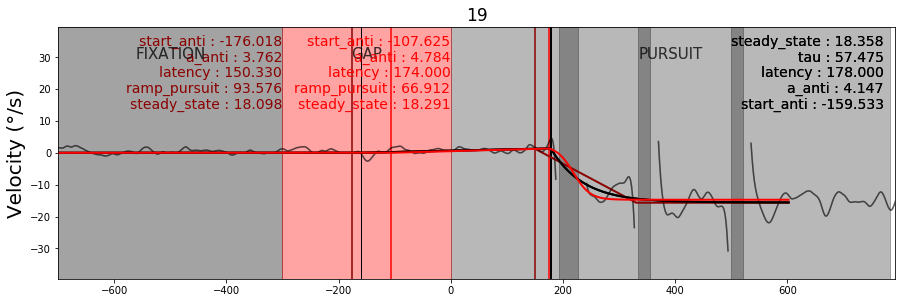

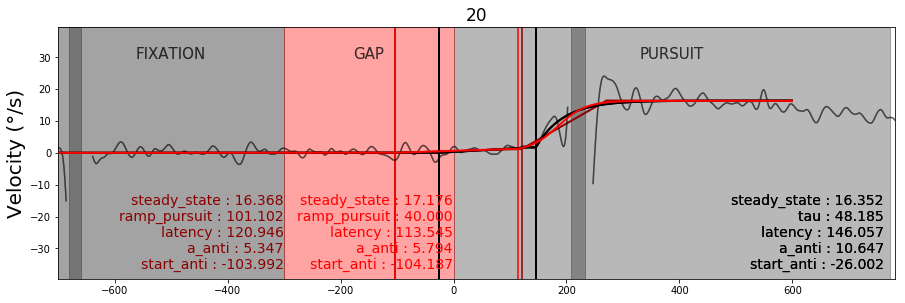

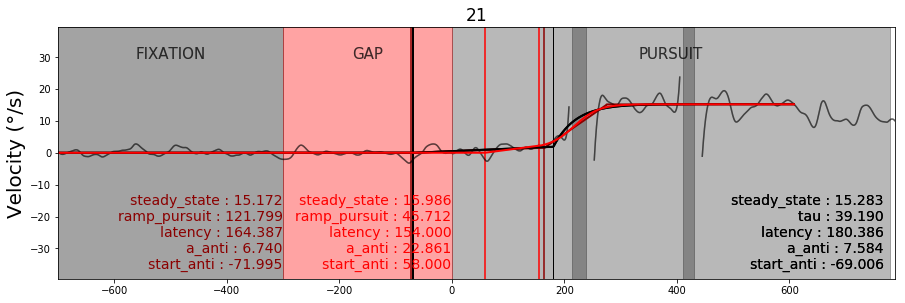

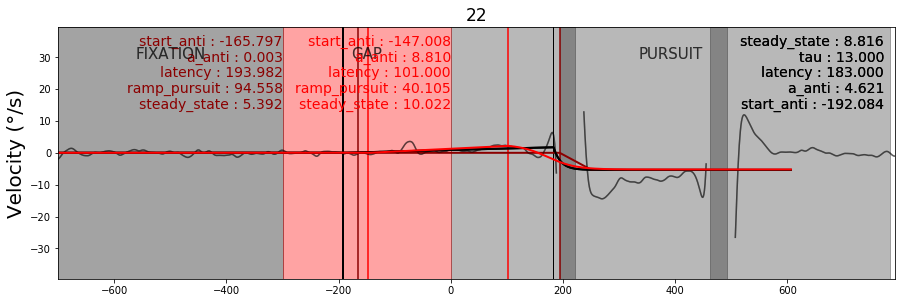

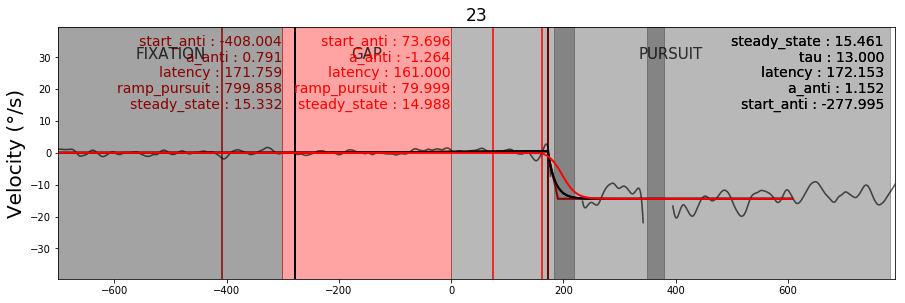

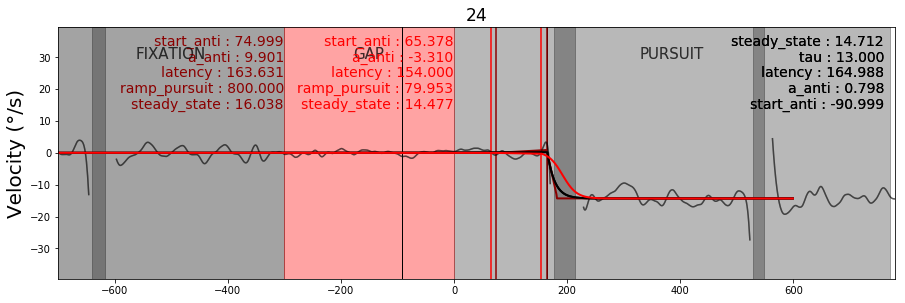

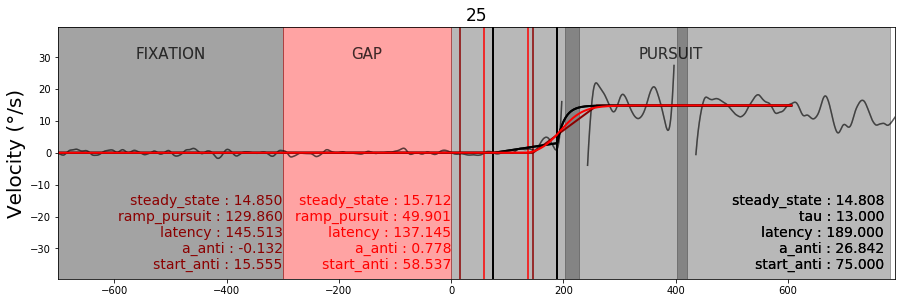

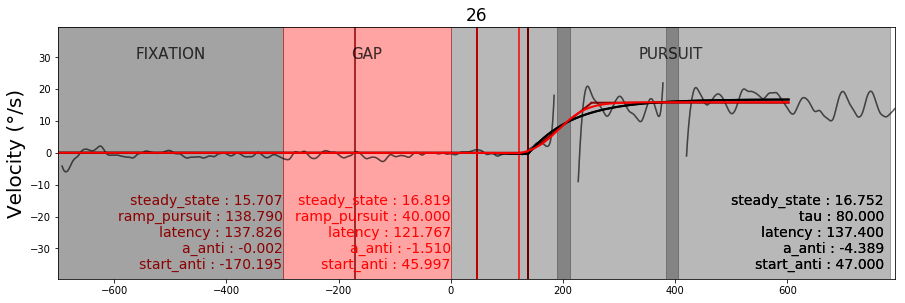

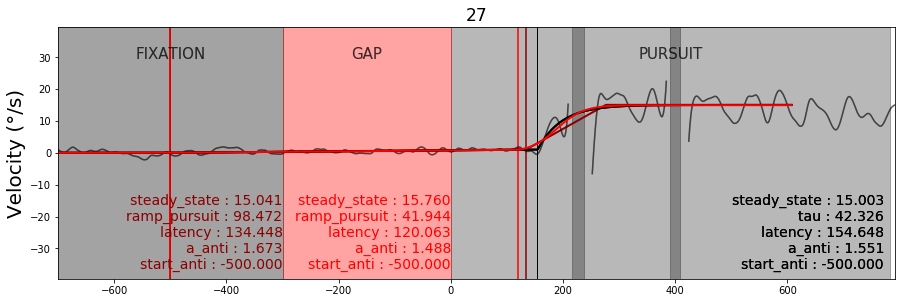

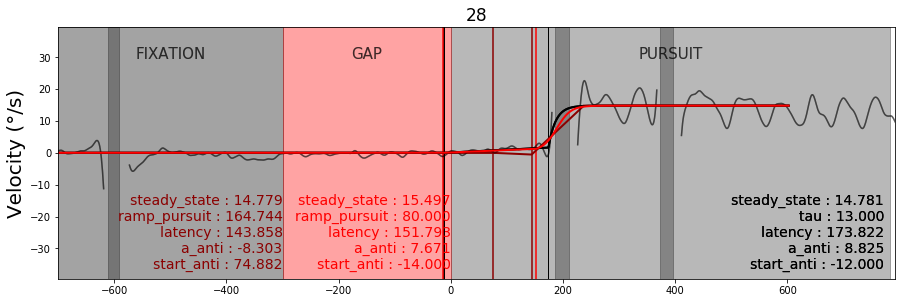

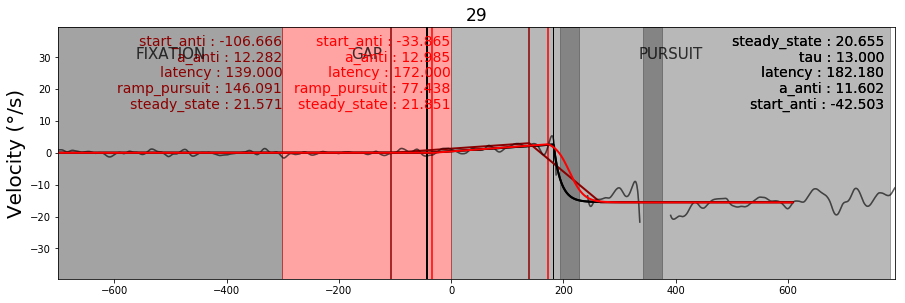

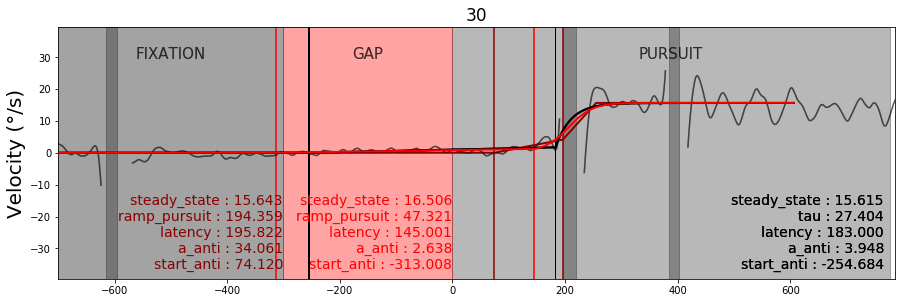

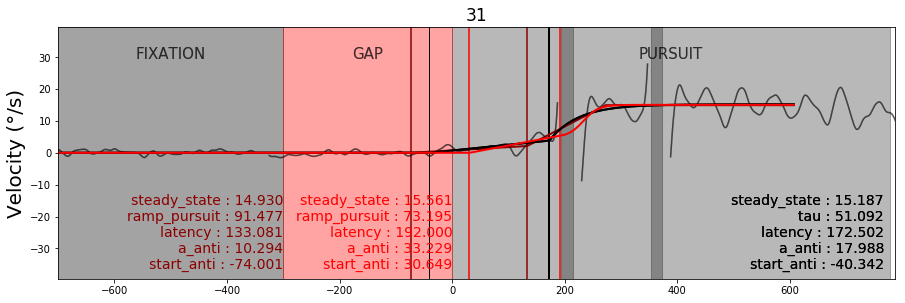

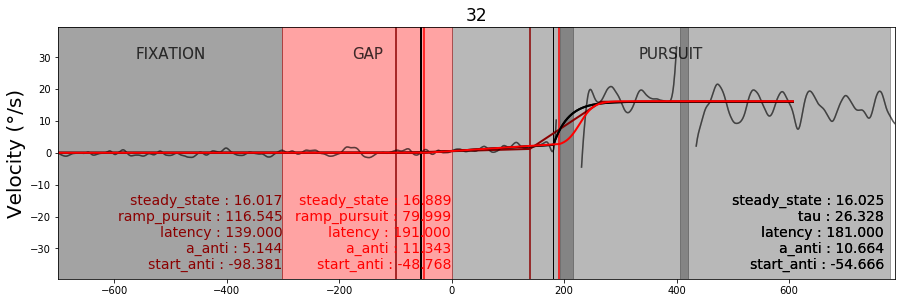

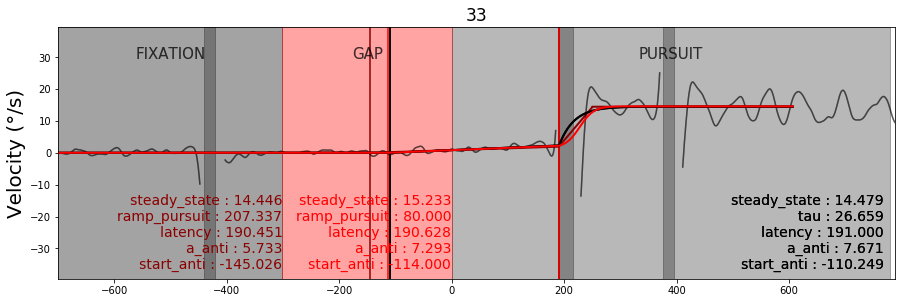

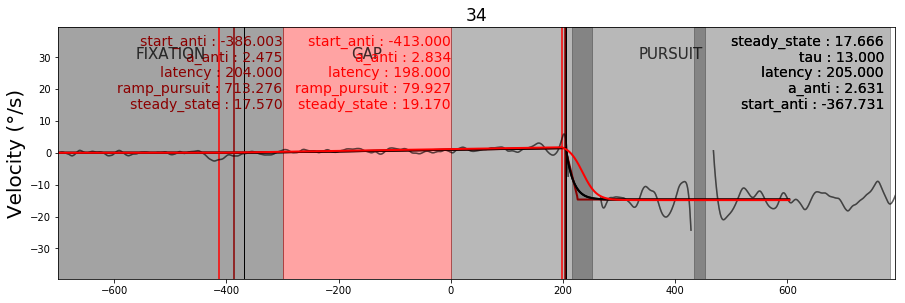

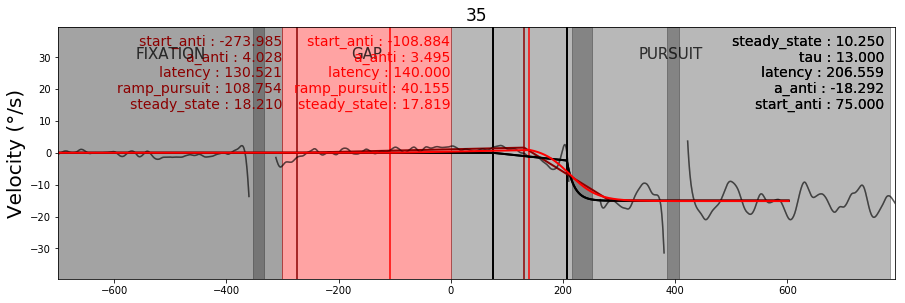

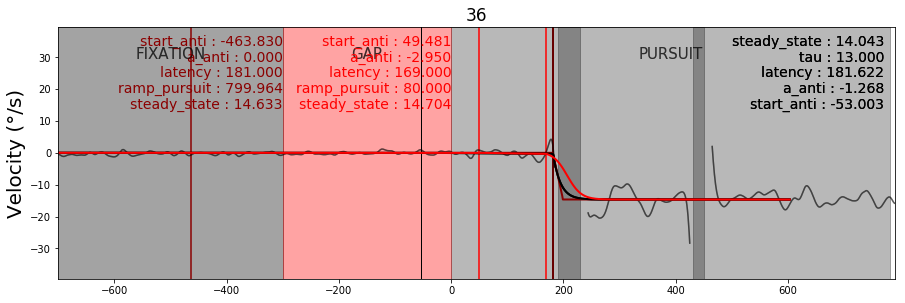

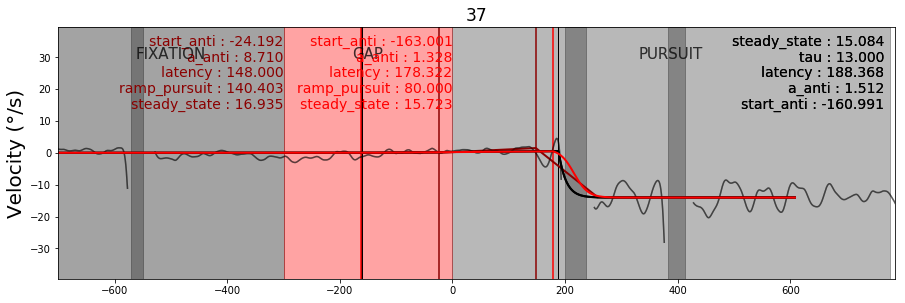

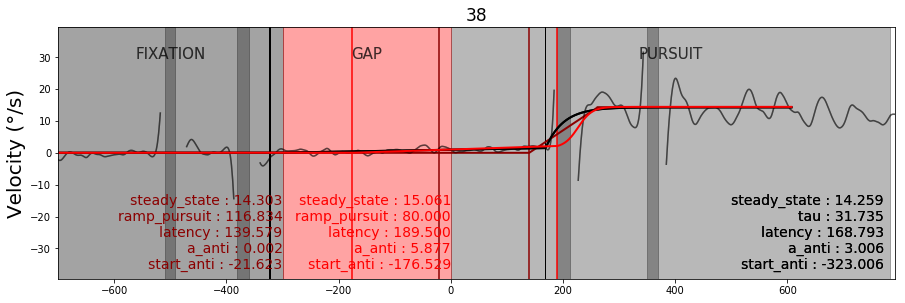

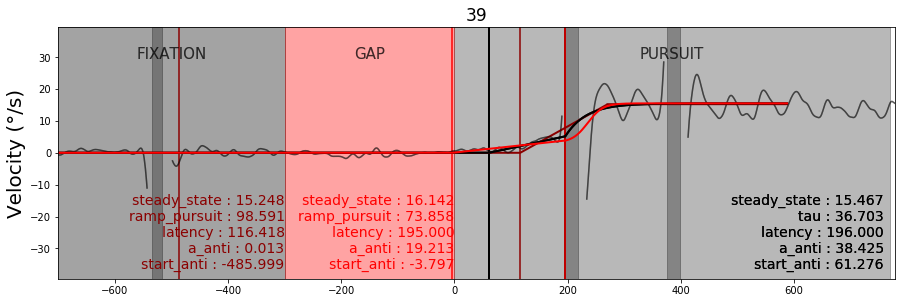

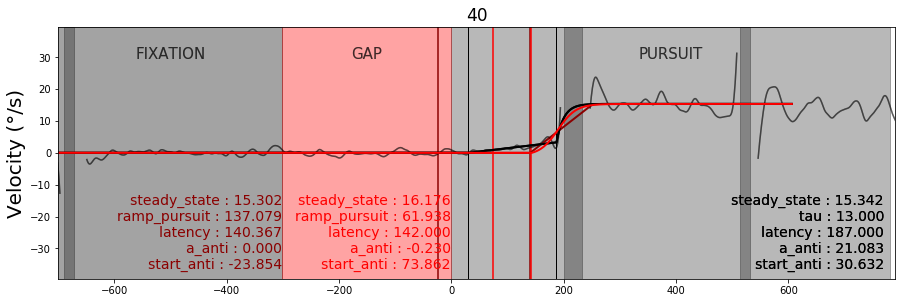

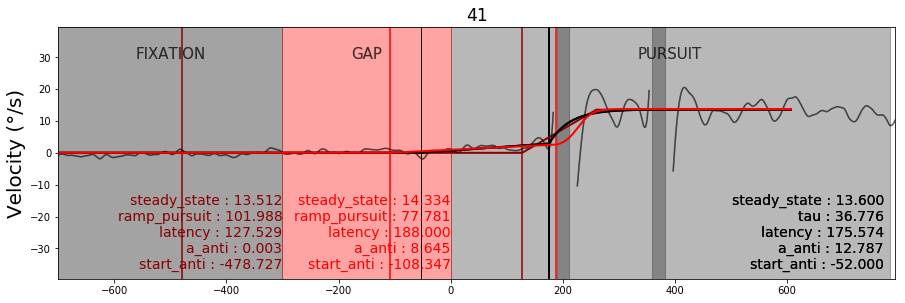

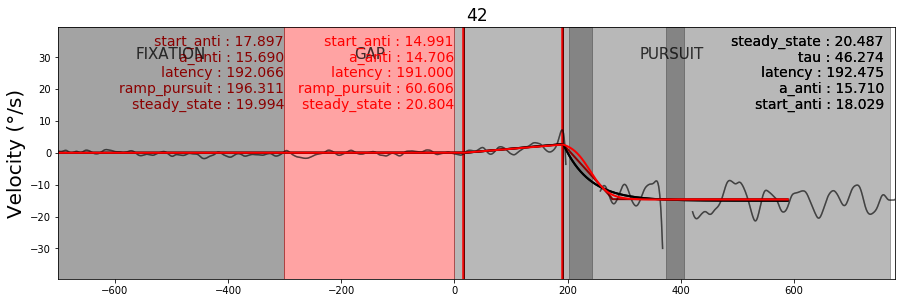

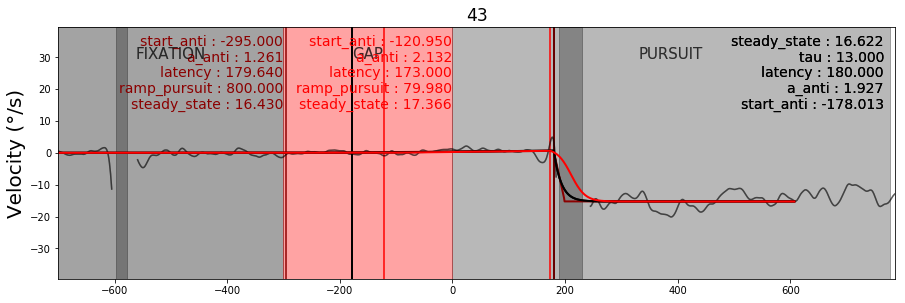

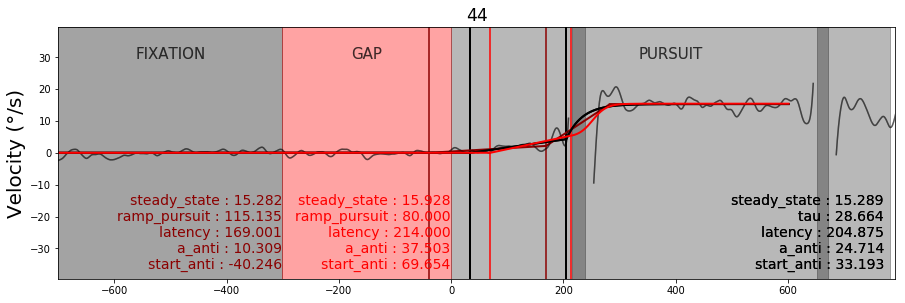

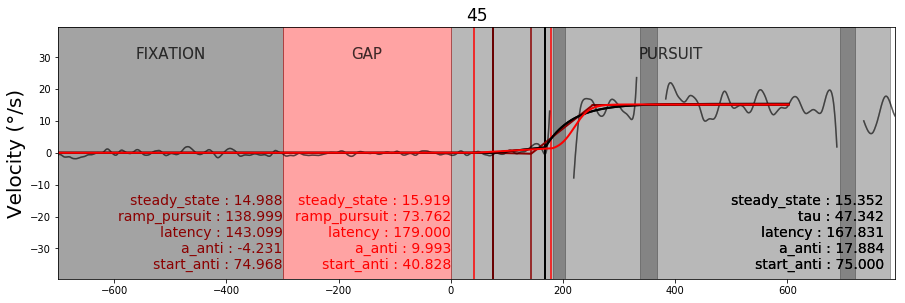

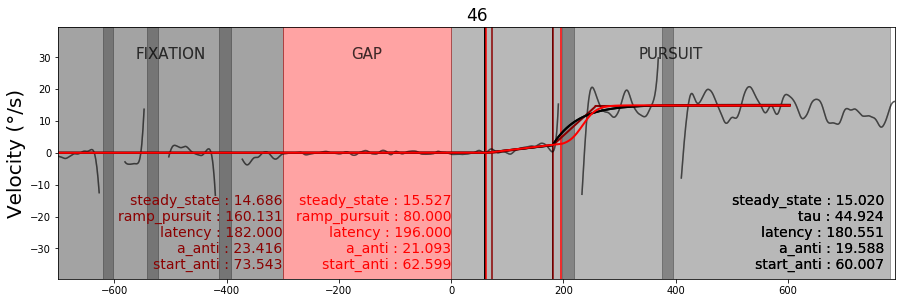

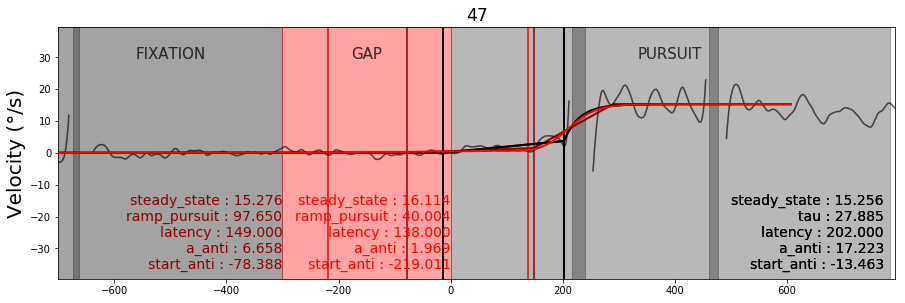

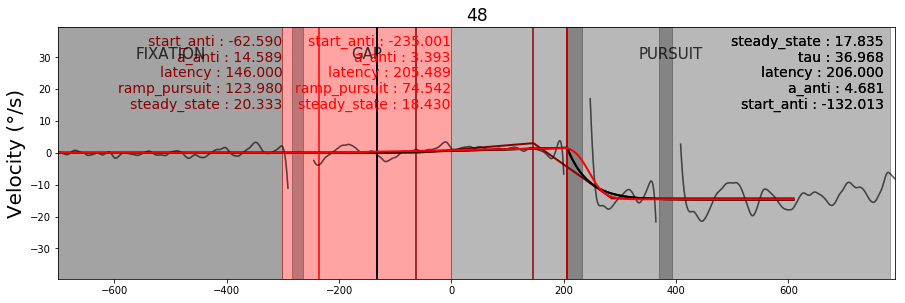

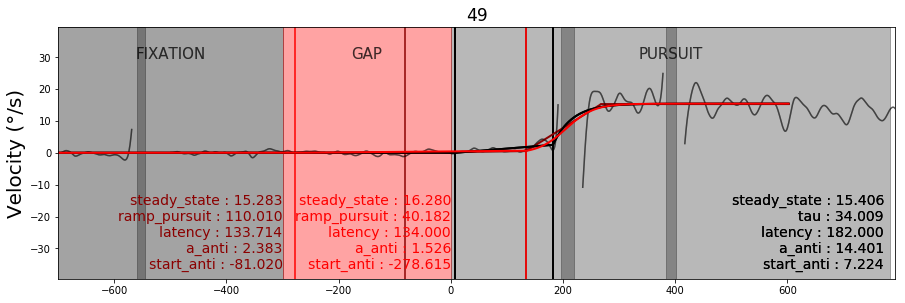

In [7]:
nb_trial = 50
#fig, axs = plt.subplots(nb_trial, 1, figsize=(15, (15*(nb_trial/2))/1.6180))

block = 0
for trial in range(nb_trial) :
    fig, ax = plt.subplots(1, 1, figsize=(15, (15*(1/2))/1.6180))
    
    #ax=axs[trial]
    
    time_sup = 280

    trial_data = trial + exp['N_trials']*block
    arg = A.arg(data[trial_data], trial=trial, block=block)
    
    velocity_NAN = A.velocity_NAN(**arg, filt='velocity')

    data_trial = velocity_NAN[:-time_sup]
    trackertime = arg.trackertime[:-time_sup]

    max_latency = []
    for s in range(len(arg.saccades)) :
        if (arg.saccades[s][0]-arg.t_0)>=(arg.TargetOn-arg.t_0+100) : max_latency.append((arg.saccades[s][0]-arg.t_0))
    if max_latency == [] :                                              max_latency.append(len(trackertime))
    max_latency = max_latency[0]

    value_latency, value_steady_state, value_anti = A.classical_method.Full(data_trial, arg.TargetOn)
    
    if np.isnan(value_latency): value_latency= arg.TargetOn-arg.t_0+100
    if np.isnan(value_anti):    value_anti= 0.
    if np.isnan(value_steady_state):    value_steady_state= 15.


    if value_latency >= max_latency-50 : value_latency = max_latency-150
    if value_latency > 250 :             value_latency = arg.TargetOn-arg.t_0+100


    vary = False

    inde_vars={'x':np.arange(len(trackertime))}
   
    
    color=['darkred', 'r']
    
    for i, equation in enumerate([fct_velocity_line, fct_velocity_sigmo]) :
        
        if equation==fct_velocity_sigmo :
            param_fit=[{'name':'ramp_pursuit', 'value':40, 'min':40., 'max':80., 'vary':'vary'},
                       {'name':'steady_state', 'value':value_steady_state, 'min':5., 'max':40., 'vary':True},
                       {'name':'dir_target', 'value':arg.dir_target, 'min':None, 'max':None, 'vary':False},
                       {'name':'a_anti', 'value':value_anti, 'min':-40., 'max':40., 'vary':True},
                       {'name':'latency', 'value':value_latency, 'min':arg.TargetOn-arg.t_0+75,
                        'max':max_latency, 'vary':True},
                       {'name':'start_anti', 'value':arg.TargetOn-arg.t_0-100, 'min':arg.StimulusOf-arg.t_0-200,
                        'max':arg.TargetOn-arg.t_0+75, 'vary':'vary'}]
        
        else :
            param_fit=[{'name':'ramp_pursuit', 'value':100, 'min':40., 'max':800., 'vary':'vary'},
                       {'name':'steady_state', 'value':value_steady_state, 'min':5., 'max':40., 'vary':True},
                       {'name':'dir_target', 'value':arg.dir_target, 'min':None, 'max':None, 'vary':False},
                       {'name':'a_anti', 'value':value_anti, 'min':-40., 'max':40., 'vary':True},
                       {'name':'latency', 'value':value_latency, 'min':arg.TargetOn-arg.t_0+75,
                        'max':max_latency, 'vary':True},
                       {'name':'start_anti', 'value':arg.TargetOn-arg.t_0-100, 'min':arg.StimulusOf-arg.t_0-200,
                        'max':arg.TargetOn-arg.t_0+75, 'vary':'vary'}]
        
        params = Parameters()
        model = Model(equation, independent_vars=inde_vars.keys())

        for num_par in range(len(param_fit)) :
            if param_fit[num_par]['vary'] == 'vary' : var = vary
            else :                                    var = param_fit[num_par]['vary']
            params.add(param_fit[num_par]['name'],
                       value=param_fit[num_par]['value'],
                       min=param_fit[num_par]['min'],
                       max=param_fit[num_par]['max'],
                       vary=var)

        params.add('do_whitening', value=False, vary=False)

        out = model.fit(data_trial, params, nan_policy='omit', **inde_vars)

        # make the other parameters vary now
        for num_par in range(len(param_fit)) :
            if param_fit[num_par]['vary'] == 'vary' :
                out.params[param_fit[num_par]['name']].set(vary=True)

        result_deg = model.fit(data_trial, out.params, method='nelder', nan_policy='omit', **inde_vars)

        #------------------------------------------------------------------------------------------------
        time = arg.trackertime[:-time_sup]-arg.TargetOn
        onset = arg.TargetOn - arg.t_0


        ax = Plot.generate_fig(ax, data, trial, block, show='fit', fig=fig, filt='velocity', **arg)
        #ax = Plot.generate_fig(ax, data, trial, block, show='data', fig=fig, filt='velocity', **arg)

        ax.plot(time, equation(np.arange(len(arg.trackertime[:-time_sup])), **result_deg.values), c=color[i], lw=2)
        ax.vlines(result_deg.values['start_anti']-onset, -40, 40, colors=color[i])
        ax.vlines(result_deg.values['latency']-onset, -40, 40, colors=color[i])

        list_param = ['start_anti', 'a_anti', 'latency', 'ramp_pursuit', 'steady_state']

        param_ = {}
        for name in result_deg.values.keys() :
            if name in ['latency', 'start_anti'] : param_[name] = result_deg.values[name]-onset
            else : param_[name] = result_deg.values[name]

        ax.set_title(trial, fontsize=17)
        ax.set_xlabel('')
        x = 0
        for name in list_param :
            ax.text((arg.StimulusOf-arg.TargetOn)+300*i, -arg.dir_target*35+(-arg.dir_target*x),
                    "%s : %0.3f"%(name, param_[name]) , color=color[i], size=14, va='center', ha='right')
            x = x - 5
    plt.show()
#plt.show()